In [1]:
import os

from fastai.vision.all import *
from fastai.vision import *

import pandas as pd

In [18]:
import os
from sklearn.model_selection import train_test_split

# Define the path to the dataset
TRAIN_DATASET_PATH = '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_filtered'

# Get the list of image paths
image_paths = []
labels = []

for folder_name in os.listdir(TRAIN_DATASET_PATH):
    class_name = folder_name
    class_path = os.path.join(TRAIN_DATASET_PATH, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image_paths.append(image_path)
        labels.append(class_name)

# Split the dataset into train and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42, stratify=labels)

# Create directories for train and test sets
train_dir = os.path.join(TRAIN_DATASET_PATH, 'train')
test_dir = os.path.join(TRAIN_DATASET_PATH, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Move images to train directory
for path, label in zip(train_paths, train_labels):
    class_dir = os.path.join(train_dir, label)
    os.makedirs(class_dir, exist_ok=True)
    os.rename(path, os.path.join(class_dir, os.path.basename(path)))

# Move images to test directory
for path, label in zip(test_paths, test_labels):
    class_dir = os.path.join(test_dir, label)
    os.makedirs(class_dir, exist_ok=True)
    os.rename(path, os.path.join(class_dir, os.path.basename(path)))

# Print the number of samples in each set
print(f"Number of samples in train set: {len(train_paths)}")
print(f"Number of samples in test set: {len(test_paths)}")


Number of samples in train set: 784
Number of samples in test set: 197


In [19]:
TRAIN_DATASET_PATH = '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_filtered/train'
TEST_DATASET_PATH = '/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_filtered/test'


In [20]:
# models to compare 
available_models = {
    'alexnet': models.alexnet,
    # 'resnet34': models.resnet34,
    # 'resnet50': models.resnet50,
    # 'resnet101': models.resnet101,
    # 'resnet152': models.resnet152,
    # 'resnext50_32x4d': models.resnext50_32x4d,
    # 'resnext101_32x8d': models.resnext101_32x8d,
    # 'wide_resnet50_2': models.wide_resnet50_2,
    # 'wide_resnet101_2': models.wide_resnet101_2,
    # 'vgg16_bn': models.vgg16_bn,
    # 'vgg19_bn': models.vgg19_bn,
    # 'squeezenet1_1': models.squeezenet1_1,
    # 'densenet121': models.densenet121,
    # 'densenet169': models.densenet169,
    # 'densenet201': models.densenet201,
}

In [21]:
# create csv for the trichome dataset
class_names = []
for folder_name in os.listdir(TEST_DATASET_PATH):
    class_names.append(folder_name)
    
print(f"classes names:\n {class_names}")

image_paths = []
labels = []

for i in range(len(class_names)):
    class_name = class_names[i]
    image_names = os.listdir(f'{TEST_DATASET_PATH}/{class_name}')
    for image_name in image_names:
        image_path = f'{TEST_DATASET_PATH}/{class_name}/{image_name}'
        image_paths.append(image_path)
        labels.append(i)
        
        
df = pd.DataFrame(
    {
        'name': image_paths,
        'label': labels
    }
)

# if you want to save the to csv
# df.to_csv(
#     path_or_buf=f'{TRAIN_DATASET_PATH}/labels.csv',
#     index=False
# )

df.head()

classes names:
 ['cloudy', 'clear', 'amber']


,name,label
0,/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_filtered/test/cloudy/IMG_0581_trichome_128_bbox_253_423_302_474.png,0
1,/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_filtered/test/cloudy/IMG_1818_trichome_124_bbox_276_205_325_254.png,0
2,/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_filtered/test/cloudy/IMG_2145_trichome_23_bbox_228_61_291_129.png,0
3,/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_filtered/test/cloudy/IMG_0003_trichome_65_bbox_312_73_360_122.png,0
4,/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_train_26-04-2024_15-44-44/ground_truth_trichomes_datasets/trichome_dataset_125_filtered/test/cloudy/IMG_0045_trichome_200_bbox_148_369_204_437.png,0


In [22]:
# dist of the df data
df['label'].value_counts()

label
0    134
1     51
2     12
Name: count, dtype: int64

## Images Transformation Experiment
I want to compare the results when performing transformations like resize or color shifting for the images to see if I can get better results.
I will use a slim model to run the comparisons faster.

In [23]:
# model and metrics to compare
model_name = 'alexnet'
precision_macro = Precision(average='macro')
recall_macro = Recall(average='macro')
precision_micro = Precision(average='micro')
recall_micro = RecallMulti(average='micro')
roc_auc = RocAuc()


Raw dataloader

In [24]:
# create raw dataloader
dls = ImageDataLoaders.from_folder(
    path=TRAIN_DATASET_PATH,
    item_tfms=Resize(128),
    bs=16,
    valid_pct=0.25
)

# if you want to see a sample of the data
# dls.show_batch()

In [25]:
model = vision_learner(
    dls=dls,
    arch=available_models[model_name],
    metrics=[error_rate, precision_macro, recall_macro, roc_auc]
)

model.fine_tune(
    epochs=25
)

epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,0.819888,0.605248,0.183673,0.704613,0.846804,0.921730,00:01
1,0.711182,0.507868,0.137755,0.757929,0.873504,0.941559,00:00
2,0.572803,0.393552,0.117347,0.795962,0.855476,0.939926,00:00
3,0.502080,0.375637,0.096939,0.827115,0.883845,0.968398,00:00
4,0.393042,0.381161,0.107143,0.872788,0.883584,0.950126,00:00
5,0.329733,0.292325,0.102041,0.877901,0.848922,0.957404,00:00
6,0.279422,0.245146,0.086735,0.874333,0.833085,0.978561,00:00
7,0.241177,0.269422,0.081633,0.880952,0.877274,0.962436,00:00
8,0.232901,0.193641,0.071429,0.908215,0.877551,0.972028,00:00
9,0.215237,0.277097,0.096939,0.858562,0.828183,0.973394,00:00


Resize the Image to 128 with padding

In [26]:
import PIL

# Custom transform
def custom_transform(size):
    return Resize(size, method='pad', pad_mode='zeros')

# DataLoaders with custom transform
dls = ImageDataLoaders.from_folder(
    path=TRAIN_DATASET_PATH,
    item_tfms=custom_transform(128),  # Adjust size as needed
    batch_tfms=aug_transforms(size=128),  # Apply data augmentation
    bs=16,
    valid_pct=0.25
)


# if you want to see a sample of the data
# dls.show_batch()

In [27]:
model = vision_learner(
    dls=dls,
    arch=available_models[model_name],
    metrics=[error_rate, precision_macro, recall_macro, roc_auc]
)

model.fine_tune(
    epochs=25
)

epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.546309,0.594056,0.219388,0.662408,0.770317,0.921209,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,0.900140,0.503120,0.188776,0.679799,0.794724,0.953638,00:01
1,0.846821,0.369571,0.132653,0.774487,0.851825,0.962966,00:01
2,0.808055,0.330831,0.122449,0.784709,0.836251,0.967446,00:01
3,0.711978,0.296246,0.112245,0.797440,0.881788,0.975645,00:01
4,0.592057,0.275984,0.091837,0.825992,0.850639,0.981603,00:01
5,0.523542,0.263157,0.102041,0.842245,0.825806,0.973390,00:01
6,0.465804,0.221352,0.086735,0.846405,0.858047,0.983295,00:01
7,0.415397,0.439543,0.147959,0.760965,0.874687,0.970992,00:01
8,0.348105,0.308328,0.127551,0.798349,0.813483,0.972859,00:01
9,0.385018,0.265040,0.112245,0.815942,0.825686,0.969647,00:01


Convert the images to HSV

In [28]:
# Custom Transform to HSV using fastai's rgb2hsv
class RGB2HSV(Transform):
    def encodes(self, img: PILImage): 
        return rgb2hsv(img)
    
# DataLoaders with custom transform to HSV
dls = ImageDataLoaders.from_folder(
    path=TRAIN_DATASET_PATH,
    item_tfms=Resize(128),  # Resize before applying HSV transform
    batch_tfms=[RGB2HSV(), *aug_transforms(size=128)],
    bs=16,
    valid_pct=0.25
)

# Check a batch to see if transformations are applied correctly
# dls.show_batch()


In [29]:
model = vision_learner(
    dls=dls,
    arch=available_models[model_name],
    metrics=[error_rate, precision_macro, recall_macro, roc_auc]
)

model.fine_tune(
    epochs=25
)

epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.387786,0.762334,0.239796,0.684549,0.775950,0.900739,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,0.855292,0.607440,0.198980,0.743452,0.820106,0.912322,00:01
1,0.766506,0.562288,0.178571,0.798851,0.830688,0.920831,00:01
2,0.685308,0.549331,0.168367,0.794774,0.835979,0.923427,00:01
3,0.620319,0.416288,0.153061,0.835566,0.814093,0.943681,00:01
4,0.525951,0.409085,0.142857,0.846309,0.819384,0.954167,00:01
5,0.450141,0.438335,0.147959,0.818182,0.813324,0.948113,00:01
6,0.402875,0.355860,0.117347,0.868504,0.865849,0.965223,00:01
7,0.347972,0.375579,0.102041,0.902315,0.854209,0.963696,00:01
8,0.338016,0.388165,0.112245,0.892605,0.842088,0.956479,00:01
9,0.273402,0.402764,0.117347,0.906061,0.826696,0.938675,00:01


Normalize the images pixels

In [30]:
# DataLoaders with custom transform to HSV
dls = ImageDataLoaders.from_folder(
    path=TRAIN_DATASET_PATH,
    item_tfms=Resize(128),  # Resize before applying HSV transform
    batch_tfms=[Normalize.from_stats(*imagenet_stats), *aug_transforms(size=128)],
    bs=16,
    valid_pct=0.25
)

# Check a batch to see if transformations are applied correctly
# dls.show_batch()


In [31]:
model = vision_learner(
    dls=dls,
    arch=available_models[model_name],
    metrics=[error_rate, precision_macro, recall_macro, roc_auc]
)

model.fine_tune(
    epochs=25
)

epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.451816,0.402621,0.142857,0.746095,0.857455,0.952378,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,0.948145,0.357597,0.112245,0.778624,0.870362,0.967493,00:01
1,0.853191,0.289985,0.091837,0.860237,0.849153,0.963523,00:01
2,0.740516,0.256349,0.081633,0.864413,0.878372,0.974229,00:01
3,0.658674,0.230196,0.081633,0.905817,0.874744,0.979274,00:01
4,0.613056,0.218343,0.056122,0.969098,0.887467,0.982869,00:01
5,0.550894,0.222045,0.071429,0.946051,0.827944,0.981370,00:01
6,0.442275,0.207353,0.071429,0.917117,0.907592,0.983795,00:01
7,0.438196,0.288054,0.076531,0.895011,0.901419,0.975698,00:01
8,0.374695,0.816743,0.147959,0.848599,0.814999,0.913122,00:01
9,0.329602,0.222193,0.081633,0.952089,0.856602,0.986542,00:01


Brightness and Contrast Adjustments

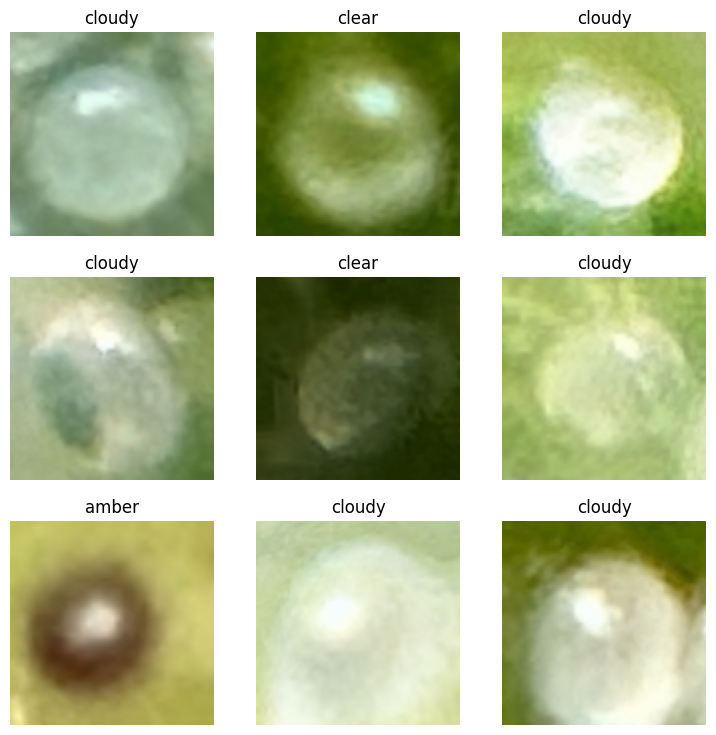

In [32]:
# DataLoaders with custom transform to HSV
dls = ImageDataLoaders.from_folder(
    path=TRAIN_DATASET_PATH,
    item_tfms=Resize(128), 
    batch_tfms=[Brightness(max_lighting=0.2, p=0.75), Contrast(max_lighting=0.2, p=0.75), *aug_transforms(size=128)],
    bs=16,
    valid_pct=0.25
)

# Check a batch to see if transformations are applied correctly
dls.show_batch()


In [33]:
model = vision_learner(
    dls=dls,
    arch=available_models[model_name],
    metrics=[error_rate, precision_macro, recall_macro, roc_auc]
)

model.fine_tune(
    epochs=25
)

epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.512436,0.582789,0.214286,0.604643,0.646332,0.853673,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,0.846193,0.426827,0.168367,0.707991,0.724004,0.924797,00:01
1,0.806300,0.338946,0.122449,0.777877,0.858368,0.968410,00:01
2,0.719567,0.323023,0.107143,0.806944,0.890808,0.961014,00:01
3,0.622907,0.243139,0.096939,0.804952,0.870023,0.980572,00:01
4,0.557788,0.245336,0.112245,0.802420,0.851432,0.976559,00:01
5,0.490170,0.319736,0.096939,0.921486,0.817831,0.954396,00:01
6,0.463745,0.297357,0.107143,0.843954,0.871160,0.976857,00:01
7,0.411504,0.308935,0.096939,0.859826,0.864224,0.975169,00:01
8,0.377270,0.216594,0.091837,0.856229,0.860756,0.982365,00:01
9,0.333367,0.260782,0.096939,0.858072,0.832978,0.963007,00:01


Combined Transformations

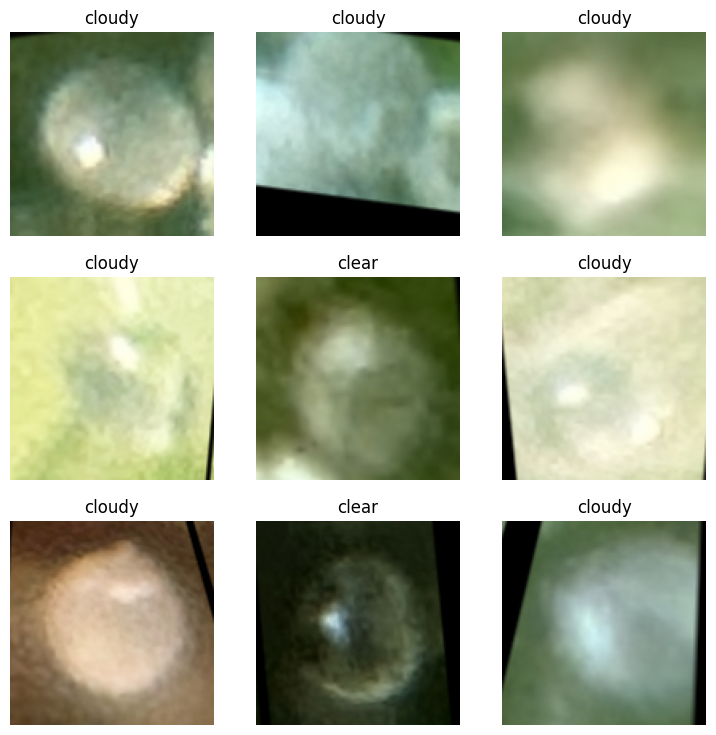

In [34]:
import PIL

# Custom transform
def custom_transform(size):
    return Resize(size, method='pad', pad_mode='zeros')

class RGB2HSV(Transform):
    def encodes(self, img: PILImage): 
        return rgb2hsv(img)

dls = ImageDataLoaders.from_folder(
    path=TRAIN_DATASET_PATH,
    item_tfms=custom_transform(size=128),  # Resize and HSV transform
    batch_tfms=[
        RGB2HSV(),
        *aug_transforms(size=128, flip_vert=True, max_rotate=10),
        Brightness(max_lighting=0.2, p=0.75),
        Contrast(max_lighting=0.2, p=0.75),
    ],
    bs=16,
    valid_pct=0.25
)

# Check a batch to see if transformations are applied correctly
dls.show_batch()

In [35]:
model = vision_learner(
    dls=dls,
    arch=available_models[model_name],
    metrics=[error_rate, precision_macro, recall_macro, roc_auc]
)

model.fine_tune(
    epochs=25
)

epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.541705,0.693615,0.250000,0.670635,0.645961,0.877623,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.066322,0.600434,0.224490,0.718558,0.710926,0.900145,00:01
1,0.883944,0.555281,0.183673,0.768382,0.779356,0.912030,00:01
2,0.792764,0.485515,0.132653,0.842826,0.837142,0.929921,00:01
3,0.739900,0.504196,0.147959,0.832221,0.801640,0.928046,00:01
4,0.623077,0.498776,0.158163,0.818981,0.776586,0.935945,00:01
5,0.557282,0.421367,0.122449,0.876250,0.794461,0.938806,00:01
6,0.493447,0.388483,0.122449,0.911688,0.790798,0.924944,00:01
7,0.448275,0.382139,0.112245,0.914893,0.791888,0.947472,00:01
8,0.379905,0.473598,0.132653,0.926701,0.777975,0.949636,00:01
9,0.373001,0.364605,0.112245,0.918517,0.807781,0.961823,00:01


In [36]:
model_saving_path = '/home/etaylor/code_projects/thesis/checkpoints/image_classification_models'
model_checkpoint = f'{model_saving_path}/{model_name}.pkl'
model.export(model_checkpoint)

### Evaluate the Model

In [37]:
from sklearn.metrics import precision_score, recall_score, accuracy_score


item_tfms=custom_transform(size=128),  # Resize and HSV transform
batch_tfms=[
    RGB2HSV(),
    *aug_transforms(size=128, flip_vert=True, max_rotate=10),
    Brightness(max_lighting=0.2, p=0.75),
    Contrast(max_lighting=0.2, p=0.75),
]

# Create the test DataLoader with the same transformations
test_dl = dls.test_dl(get_image_files(TEST_DATASET_PATH), with_labels=True, 
                    item_tfms=item_tfms, batch_tfms=batch_tfms)


# Evaluate on the test set
preds, targs = model.get_preds(dl=test_dl)


if targs is not None:
    pred_classes = preds.argmax(dim=1).numpy()
    true_classes = targs.numpy()

    precision = precision_score(true_classes, pred_classes, average='macro')
    recall = recall_score(true_classes, pred_classes, average='macro')
    accuracy = accuracy_score(true_classes, pred_classes)
else:
    precision = recall = accuracy = None

results = {
    'model': model_name,
    'precision': precision,
    'recall': recall,
    'accuracy': accuracy
}

results

{'model': 'alexnet',
 'precision': 0.9494317589406736,
 'recall': 0.9312262218320164,
 'accuracy': 0.934010152284264}

### Compare Different Models
In this section I will compare different Image classification models with the datasets created.

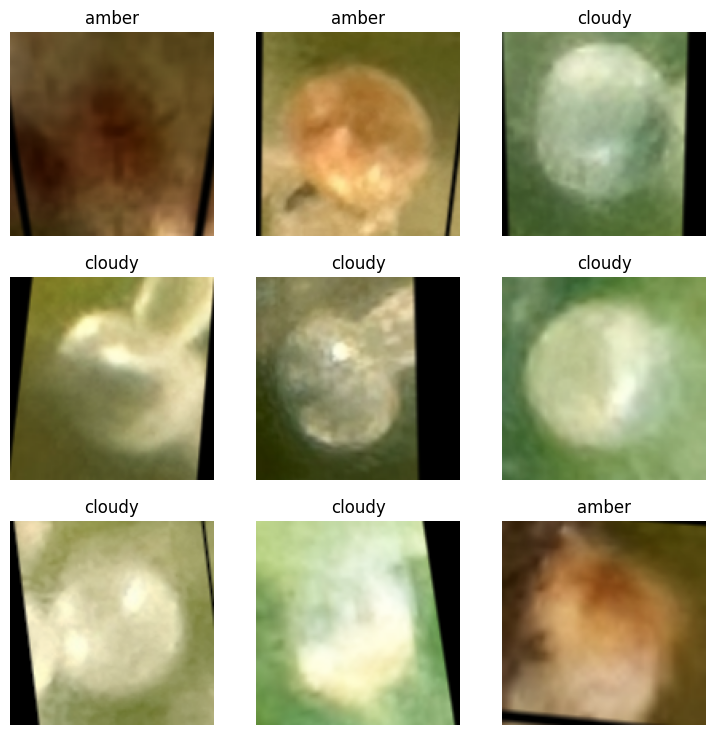

In [38]:
# lets bring the models and datasets 
available_models = {
    'alexnet': models.alexnet,
    'resnet34': models.resnet34,
    'resnet50': models.resnet50,
    'resnet101': models.resnet101,
    # 'resnet152': models.resnet152,
    'resnext50_32x4d': models.resnext50_32x4d,
    'resnext101_32x8d': models.resnext101_32x8d,
    'wide_resnet50_2': models.wide_resnet50_2,
    # 'wide_resnet101_2': models.wide_resnet101_2,
    'vgg16_bn': models.vgg16_bn,
    'vgg19_bn': models.vgg19_bn,
    'squeezenet1_1': models.squeezenet1_1,
    'densenet121': models.densenet121,
    # 'densenet169': models.densenet169,
    # 'densenet201': models.densenet201,
}

# Custom transform
def custom_transform(size):
    return Resize(size, method='pad', pad_mode='zeros')

class RGB2HSV(Transform):
    def encodes(self, img: PILImage): 
        return rgb2hsv(img)

dls = ImageDataLoaders.from_folder(
    path=TRAIN_DATASET_PATH,
    item_tfms=custom_transform(size=128),
    batch_tfms=[
        RGB2HSV(),
        *aug_transforms(size=128, flip_vert=True, max_rotate=10),
        Brightness(max_lighting=0.2, p=0.75),
        Contrast(max_lighting=0.2, p=0.75),
    ],
    bs=16,
    valid_pct=0.25
)

# Check a batch to see if transformations are applied correctly
dls.show_batch()

In [39]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

precision_macro_fastai = Precision(average='macro')
recall_macro_fastai = Recall(average='macro')
roc_auc_fastai = RocAuc()

item_tfms=custom_transform(size=128),  # Resize and HSV transform
batch_tfms=[
    RGB2HSV(),
    *aug_transforms(size=128, flip_vert=True, max_rotate=10),
    Brightness(max_lighting=0.2, p=0.75),
    Contrast(max_lighting=0.2, p=0.75),
]

#Iterate over each model and train, then evaluate on the test set and save the results
results = []

for model_name, model_fn in available_models.items():
    print(f"Training model: {model_name}")
    
    model = vision_learner(
        dls=dls,
        arch=model_fn,
        metrics=[error_rate, precision_macro_fastai, recall_macro_fastai, roc_auc]
    )

    model.fine_tune(
        epochs=50
    )

    # Create the test DataLoader with the same transformations
    test_dl = dls.test_dl(get_image_files(TEST_DATASET_PATH), with_labels=True, 
                        item_tfms=item_tfms, batch_tfms=batch_tfms)

    # Evaluate on the test set
    preds, targs = model.get_preds(dl=test_dl)

    if targs is not None:
        pred_classes = preds.argmax(dim=1).numpy()
        true_classes = targs.numpy()

        precision = precision_score(true_classes, pred_classes, average='micro')
        recall = recall_score(true_classes, pred_classes, average='micro')
        
        # calc macro precision and recall
        precision_macro = precision_score(true_classes, pred_classes, average='macro')
        recall_macro = recall_score(true_classes, pred_classes, average='macro')
        
        accuracy = accuracy_score(true_classes, pred_classes)
        conf_matrix = confusion_matrix(true_classes, pred_classes)
        
        # Calculate precision and recall for each class
        precision_per_class = precision_score(true_classes, pred_classes, average=None)
        recall_per_class = recall_score(true_classes, pred_classes, average=None)
    else:
        precision_per_class = recall_per_class = precision = recall = accuracy = roc_auc = conf_matrix = None

    results.append({
        'model': model_name,
        'precision': precision,
        'recall': recall,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'pred_classes': pred_classes,
        'true_classes': true_classes
        
    })
    
    print(f"Results for model {model_name}:")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Precision Macro: {precision_macro}")
    print(f"Recall Macro: {recall_macro}")
    print(f"Accuracy: {accuracy}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Precision per Class: {precision_per_class}")
    print(f"Recall per Class: {recall_per_class}")
    print("\n\n")
    print("\n\n")

Training model: alexnet


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.585391,0.705863,0.265306,0.640304,0.743205,0.882850,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,0.872559,0.564600,0.209184,0.688686,0.774943,0.917616,00:01
1,0.815633,0.524335,0.188776,0.726988,0.784675,0.923249,00:01
2,0.747544,0.468911,0.158163,0.762645,0.794300,0.938413,00:01
3,0.717037,0.441443,0.153061,0.767811,0.834511,0.943379,00:01
4,0.604742,0.413718,0.137755,0.779321,0.809006,0.949945,00:01
5,0.559050,0.379964,0.127551,0.810479,0.863079,0.956728,00:01
6,0.553489,0.346234,0.112245,0.873715,0.853976,0.953663,00:01
7,0.491518,0.388166,0.142857,0.792063,0.781702,0.957502,00:01
8,0.454404,0.374636,0.107143,0.846825,0.835033,0.947665,00:01
9,0.392735,0.375981,0.122449,0.831171,0.834187,0.954112,00:01


Results for model alexnet:
Precision: 0.9187817258883249
Recall: 0.9187817258883249
Precision Macro: 0.9460978835978836
Recall Macro: 0.8863281631060383
Accuracy: 0.9187817258883249
Confusion Matrix:
[[ 11   0   1]
 [  0  39  12]
 [  0   3 131]]
Precision per Class: [1.         0.92857143 0.90972222]
Recall per Class: [0.91666667 0.76470588 0.97761194]






Training model: resnet34


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.685625,0.943389,0.382653,0.504441,0.589773,0.782932,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.148538,0.705942,0.265306,0.610480,0.724787,0.875326,00:02
1,1.060759,0.647993,0.275510,0.620557,0.733364,0.895620,00:02
2,0.896748,0.747323,0.306122,0.600000,0.692415,0.870575,00:02
3,0.856271,0.548763,0.224490,0.691761,0.704994,0.893495,00:02
4,0.783047,0.532367,0.168367,0.759490,0.748160,0.888711,00:02
5,0.679433,0.523935,0.158163,0.776245,0.779377,0.920757,00:02
6,0.599239,0.499680,0.173469,0.765387,0.734299,0.938686,00:02
7,0.545360,0.514954,0.147959,0.814616,0.736516,0.943824,00:02
8,0.520278,0.478408,0.142857,0.846308,0.756830,0.946108,00:02
9,0.424942,0.419725,0.132653,0.807619,0.864141,0.962496,00:02


Results for model resnet34:
Precision: 0.9137055837563451
Recall: 0.9137055837563451
Precision Macro: 0.9231647348085704
Recall Macro: 0.8757438298702566
Accuracy: 0.9137055837563451
Confusion Matrix:
[[ 11   0   1]
 [  1  37  13]
 [  0   2 132]]
Precision per Class: [0.91666667 0.94871795 0.90410959]
Recall per Class: [0.91666667 0.7254902  0.98507463]






Training model: resnet50


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.757209,1.416220,0.413265,0.507149,0.600046,0.769518,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.412249,1.150353,0.372449,0.531910,0.652315,0.802587,00:02
1,1.247639,1.045720,0.346939,0.572812,0.727131,0.856253,00:02
2,1.155680,0.948114,0.336735,0.561250,0.641517,0.841821,00:02
3,1.008704,0.968412,0.321429,0.620641,0.668714,0.834224,00:02
4,0.974507,0.731576,0.295918,0.566270,0.619708,0.854333,00:02
5,0.839194,0.650401,0.204082,0.702742,0.699803,0.861724,00:02
6,0.755894,0.709664,0.219388,0.680935,0.730282,0.866804,00:02
7,0.660093,0.639847,0.188776,0.747153,0.749855,0.896248,00:02
8,0.613455,0.673690,0.209184,0.704570,0.702344,0.888642,00:02
9,0.553812,0.643446,0.193878,0.769772,0.704669,0.886504,00:02


Results for model resnet50:
Precision: 0.9187817258883249
Recall: 0.9187817258883249
Precision Macro: 0.9574442863916549
Recall Macro: 0.8782313920593112
Accuracy: 0.9187817258883249
Confusion Matrix:
[[ 11   0   1]
 [  0  37  14]
 [  0   1 133]]
Precision per Class: [1.         0.97368421 0.89864865]
Recall per Class: [0.91666667 0.7254902  0.99253731]






Training model: resnet101


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.649666,1.177677,0.341837,0.550652,0.634110,0.799037,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.217155,1.133304,0.367347,0.570292,0.705971,0.826114,00:04
1,1.095812,1.063688,0.341837,0.580845,0.698239,0.844651,00:04
2,0.992784,0.880228,0.295918,0.597835,0.707230,0.860289,00:04
3,0.890723,0.942640,0.311224,0.609836,0.704905,0.877881,00:04
4,0.832489,0.767733,0.280612,0.668742,0.742359,0.890186,00:04
5,0.815529,0.674618,0.219388,0.694720,0.738752,0.893478,00:04
6,0.715508,0.850050,0.224490,0.738422,0.757695,0.884428,00:04
7,0.643009,0.726721,0.219388,0.718056,0.776530,0.904635,00:04
8,0.627101,0.837584,0.260204,0.737760,0.729236,0.880312,00:04
9,0.552695,0.646863,0.209184,0.745689,0.755046,0.912958,00:04


Results for model resnet101:
Precision: 0.9187817258883249
Recall: 0.9187817258883249
Precision Macro: 0.9408232339775084
Recall Macro: 0.9116183786947615
Accuracy: 0.9187817258883249
Confusion Matrix:
[[ 12   0   0]
 [  0  39  12]
 [  0   4 130]]
Precision per Class: [1.         0.90697674 0.91549296]
Recall per Class: [1.         0.76470588 0.97014925]






Training model: resnext50_32x4d


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.840403,2.254623,0.479592,0.516855,0.657417,0.802587,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.243713,1.261485,0.397959,0.514148,0.605866,0.812449,00:04
1,1.146209,1.164166,0.377551,0.547101,0.697609,0.847509,00:04
2,1.045355,0.990669,0.316327,0.566066,0.662677,0.839645,00:04
3,0.949772,0.913044,0.295918,0.586249,0.695265,0.860768,00:04
4,0.885533,0.936309,0.306122,0.581167,0.683945,0.852724,00:04
5,0.766076,0.819349,0.285714,0.602073,0.713575,0.872050,00:04
6,0.700330,0.796440,0.204082,0.696623,0.732607,0.863793,00:04
7,0.711768,0.957250,0.316327,0.591586,0.682574,0.858913,00:04
8,0.640667,0.729142,0.239796,0.669521,0.695678,0.863801,00:04
9,0.591953,0.808593,0.234694,0.732032,0.759282,0.872119,00:04


Results for model resnext50_32x4d:
Precision: 0.8883248730964467
Recall: 0.8883248730964467
Precision Macro: 0.93
Recall Macro: 0.8471124768315287
Accuracy: 0.8883248730964467
Confusion Matrix:
[[ 11   0   1]
 [  0  33  18]
 [  0   3 131]]
Precision per Class: [1.         0.91666667 0.87333333]
Recall per Class: [0.91666667 0.64705882 0.97761194]






Training model: resnext101_32x8d


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.589712,2.084254,0.520408,0.553401,0.554868,0.804569,00:06


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.077520,0.875570,0.280612,0.617731,0.752308,0.888835,00:10
1,0.972175,0.916243,0.275510,0.624821,0.739818,0.890750,00:10
2,0.907768,0.650639,0.209184,0.687892,0.782876,0.910544,00:10
3,0.828513,0.761875,0.209184,0.684531,0.815680,0.912463,00:10
4,0.692985,0.659483,0.209184,0.707837,0.756525,0.911736,00:10
5,0.710311,0.598767,0.178571,0.769185,0.782551,0.909861,00:10
6,0.603151,0.662951,0.168367,0.765428,0.838640,0.919180,00:10
7,0.595589,0.605019,0.173469,0.811519,0.770598,0.918033,00:10
8,0.538179,0.560698,0.173469,0.746597,0.794933,0.911037,00:10
9,0.473619,0.554885,0.168367,0.775196,0.812289,0.923902,00:10


Results for model resnext101_32x8d:
Precision: 0.9187817258883249
Recall: 0.9187817258883249
Precision Macro: 0.9367724867724867
Recall Macro: 0.9156667642181251
Accuracy: 0.9187817258883249
Confusion Matrix:
[[ 12   0   0]
 [  0  40  11]
 [  0   5 129]]
Precision per Class: [1.         0.88888889 0.92142857]
Recall per Class: [1.         0.78431373 0.96268657]






Training model: wide_resnet50_2


/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/etaylor/.conda/envs/detectron_fastai/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.690502,2.012769,0.418367,0.547287,0.696563,0.818876,00:03


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.266536,1.060526,0.316327,0.602700,0.743745,0.871834,00:04
1,1.179951,0.780862,0.285714,0.629023,0.749874,0.876979,00:04
2,1.043494,0.856754,0.331633,0.594396,0.721523,0.892684,00:04
3,0.931479,0.641447,0.239796,0.659615,0.745422,0.885638,00:04
4,0.887997,0.612898,0.244898,0.653327,0.747963,0.899977,00:04
5,0.799619,0.619086,0.229592,0.647560,0.713988,0.888198,00:04
6,0.754536,0.549423,0.204082,0.675449,0.693350,0.898390,00:04
7,0.683909,0.645875,0.239796,0.686418,0.793149,0.891385,00:04
8,0.633231,0.469134,0.178571,0.717863,0.769644,0.926918,00:04
9,0.603368,0.688238,0.244898,0.651157,0.747963,0.891788,00:04


Results for model wide_resnet50_2:
Precision: 0.9086294416243654
Recall: 0.9086294416243654
Precision Macro: 0.9358465608465608
Recall Macro: 0.8773046532045653
Accuracy: 0.9086294416243654
Confusion Matrix:
[[ 11   0   1]
 [  0  38  13]
 [  0   4 130]]
Precision per Class: [1.         0.9047619  0.90277778]
Recall per Class: [0.91666667 0.74509804 0.97014925]






Training model: vgg16_bn


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.590789,0.756853,0.290816,0.586700,0.674843,0.831146,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.036560,0.638449,0.275510,0.582076,0.629440,0.859162,00:03
1,0.961739,0.598220,0.219388,0.647765,0.697478,0.875763,00:03
2,0.894141,0.589093,0.229592,0.638983,0.702561,0.894010,00:03
3,0.810107,0.544599,0.198980,0.697100,0.707210,0.897354,00:03
4,0.715451,0.493334,0.147959,0.781930,0.751439,0.911046,00:03
5,0.605175,0.496909,0.173469,0.740850,0.707948,0.913966,00:03
6,0.492068,0.490225,0.173469,0.775670,0.661700,0.917054,00:03
7,0.461406,0.588114,0.168367,0.758889,0.631329,0.906813,00:03
8,0.405805,0.526657,0.153061,0.895506,0.645082,0.924263,00:03
9,0.333098,0.512109,0.117347,0.888368,0.729738,0.916163,00:03


Results for model vgg16_bn:
Precision: 0.9035532994923858
Recall: 0.9035532994923858
Precision Macro: 0.9510056414029924
Recall Macro: 0.8373817188566969
Accuracy: 0.9035532994923858
Confusion Matrix:
[[ 10   0   2]
 [  0  35  16]
 [  0   1 133]]
Precision per Class: [1.         0.97222222 0.8807947 ]
Recall per Class: [0.83333333 0.68627451 0.99253731]






Training model: vgg19_bn


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.510632,0.903659,0.362245,0.544057,0.630831,0.808430,00:02


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.028854,0.672771,0.285714,0.589302,0.623095,0.846057,00:03
1,1.003681,0.627465,0.224490,0.704365,0.700019,0.863235,00:03
2,0.885746,0.627753,0.214286,0.750593,0.709860,0.863475,00:03
3,0.804423,0.525281,0.168367,0.802998,0.698953,0.894268,00:03
4,0.690611,0.487227,0.147959,0.805395,0.747943,0.913881,00:03
5,0.627170,0.501306,0.132653,0.852240,0.753764,0.924213,00:03
6,0.589192,0.480409,0.122449,0.904709,0.760109,0.902216,00:03
7,0.518441,0.495485,0.132653,0.863335,0.755243,0.900054,00:03
8,0.409150,0.581600,0.153061,0.808812,0.750485,0.884390,00:03
9,0.405422,0.414649,0.107143,0.895067,0.841486,0.937628,00:03


Results for model vgg19_bn:
Precision: 0.9289340101522843
Recall: 0.9289340101522843
Precision Macro: 0.9617726261561877
Recall Macro: 0.9125451175495073
Accuracy: 0.9289340101522843
Confusion Matrix:
[[ 12   0   0]
 [  0  38  13]
 [  0   1 133]]
Precision per Class: [1.         0.97435897 0.9109589 ]
Recall per Class: [1.         0.74509804 0.99253731]






Training model: squeezenet1_1


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.404402,0.956392,0.295918,0.586626,0.675368,0.848218,00:01


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.126881,0.764488,0.275510,0.612539,0.693570,0.835378,00:01
1,0.981098,0.759373,0.209184,0.686568,0.761499,0.877307,00:01
2,0.881778,0.601932,0.198980,0.727680,0.792716,0.908454,00:01
3,0.775140,0.520351,0.178571,0.756394,0.797474,0.915427,00:01
4,0.760009,0.469905,0.178571,0.747051,0.754721,0.917567,00:01
5,0.699856,0.445498,0.188776,0.758571,0.749855,0.929887,00:01
6,0.638634,0.468239,0.183673,0.824218,0.643390,0.932245,00:01
7,0.555718,0.473242,0.158163,0.799185,0.775882,0.906796,00:01
8,0.505205,0.406380,0.137755,0.851852,0.795563,0.928232,00:01
9,0.496714,0.503168,0.158163,0.813301,0.664025,0.895090,00:01


Results for model squeezenet1_1:
Precision: 0.9086294416243654
Recall: 0.9086294416243654
Precision Macro: 0.9468699468699469
Recall Macro: 0.8479660520924788
Accuracy: 0.9086294416243654
Confusion Matrix:
[[ 10   0   2]
 [  0  37  14]
 [  0   2 132]]
Precision per Class: [1.         0.94871795 0.89189189]
Recall per Class: [0.83333333 0.7254902  0.98507463]






Training model: densenet121


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.632404,0.833666,0.316327,0.573235,0.695481,0.822033,00:04


epoch,train_loss,valid_loss,error_rate,precision_score,recall_score,roc_auc_score,time
0,1.149570,0.695702,0.224490,0.698198,0.693029,0.856357,00:04
1,0.983921,0.677314,0.193878,0.765700,0.785201,0.889626,00:04
2,0.841601,0.602109,0.193878,0.777178,0.768799,0.897085,00:04
3,0.775436,0.614887,0.204082,0.730863,0.788804,0.924420,00:04
4,0.705718,0.533284,0.173469,0.775421,0.851130,0.927676,00:04
5,0.588590,0.688208,0.209184,0.787919,0.760020,0.904178,00:04
6,0.562002,0.748144,0.173469,0.831734,0.743711,0.882192,00:04
7,0.534228,0.611317,0.168367,0.850529,0.754613,0.870981,00:04
8,0.531883,0.563937,0.178571,0.785688,0.726891,0.906012,00:04
9,0.469256,0.509851,0.127551,0.900635,0.795454,0.905940,00:04


Results for model densenet121:
Precision: 0.8984771573604061
Recall: 0.8984771573604061
Precision Macro: 0.9414814814814815
Recall Macro: 0.8561359867330016
Accuracy: 0.8984771573604061
Confusion Matrix:
[[ 11   0   1]
 [  0  34  17]
 [  0   2 132]]
Precision per Class: [1.         0.94444444 0.88      ]
Recall per Class: [0.91666667 0.66666667 0.98507463]








In [15]:
results

[{'model': 'alexnet',
  'precision': 0.7371428571428571,
  'recall': 0.7371428571428571,
  'precision_macro': 0.7563211258791966,
  'recall_macro': 0.7579710625687636,
  'precision_per_class': array([0.78313253, 0.79878049, 0.68705036]),
  'recall_per_class': array([0.84415584, 0.60648148, 0.82327586]),
  'accuracy': 0.7371428571428571,
  'confusion_matrix': array([[ 65,   2,  10],
         [  8, 131,  77],
         [ 10,  31, 191]]),
  'pred_classes': array([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 2,
         2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2,
         1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
         0, 2, 2, 2, 1, 2, 1, 2, 2, 2, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
         1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 0, 2, 2, 1, 0, 0, 1, 1,
         1, 1, 2, 1,

<Figure size 1400x800 with 0 Axes>

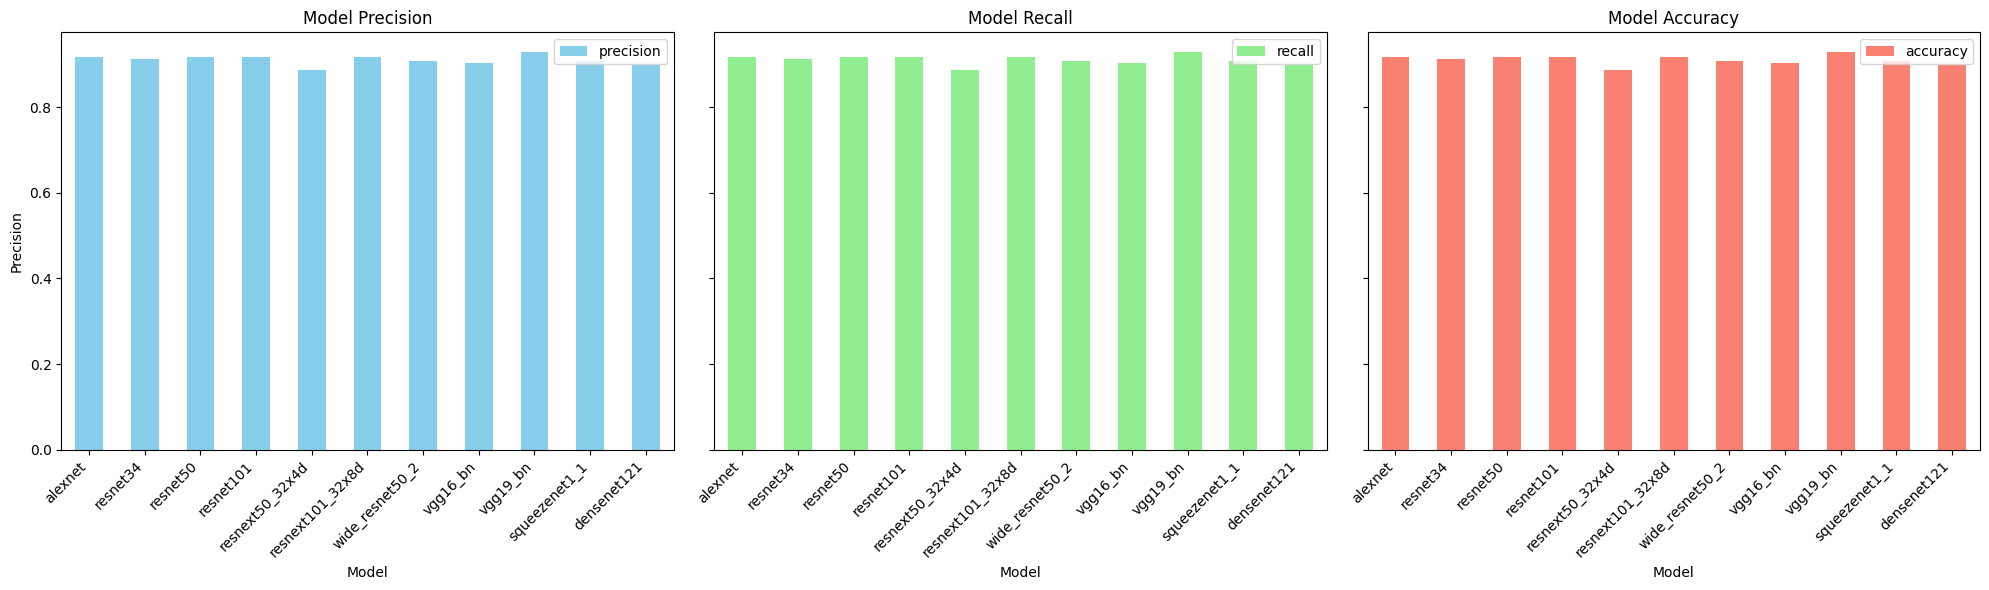

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(results)


# Set the size of the plot
plt.figure(figsize=(14, 8))

# Create subplots for each metric
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# Plot Precision
df.plot(kind='bar', x='model', y='precision', ax=axes[0], color='skyblue')
axes[0].set_title('Model Precision')
axes[0].set_ylabel('Precision')

# Plot Recall
df.plot(kind='bar', x='model', y='recall', ax=axes[1], color='lightgreen')
axes[1].set_title('Model Recall')

# Plot Accuracy
df.plot(kind='bar', x='model', y='accuracy', ax=axes[2], color='salmon')
axes[2].set_title('Model Accuracy')

# Set common properties
for ax in axes:
    ax.set_xlabel('Model')
    ax.set_xticklabels(df['model'], rotation=45, ha='right')

plt.tight_layout()
plt.show()


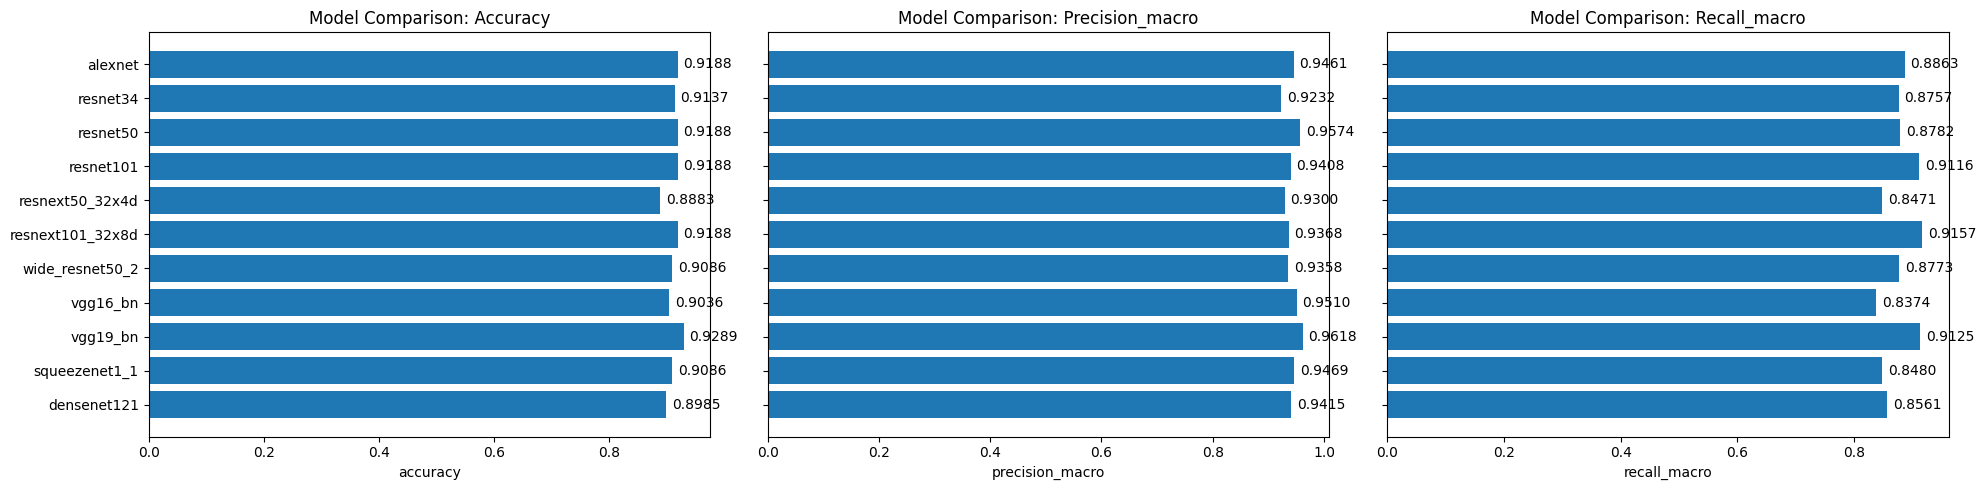

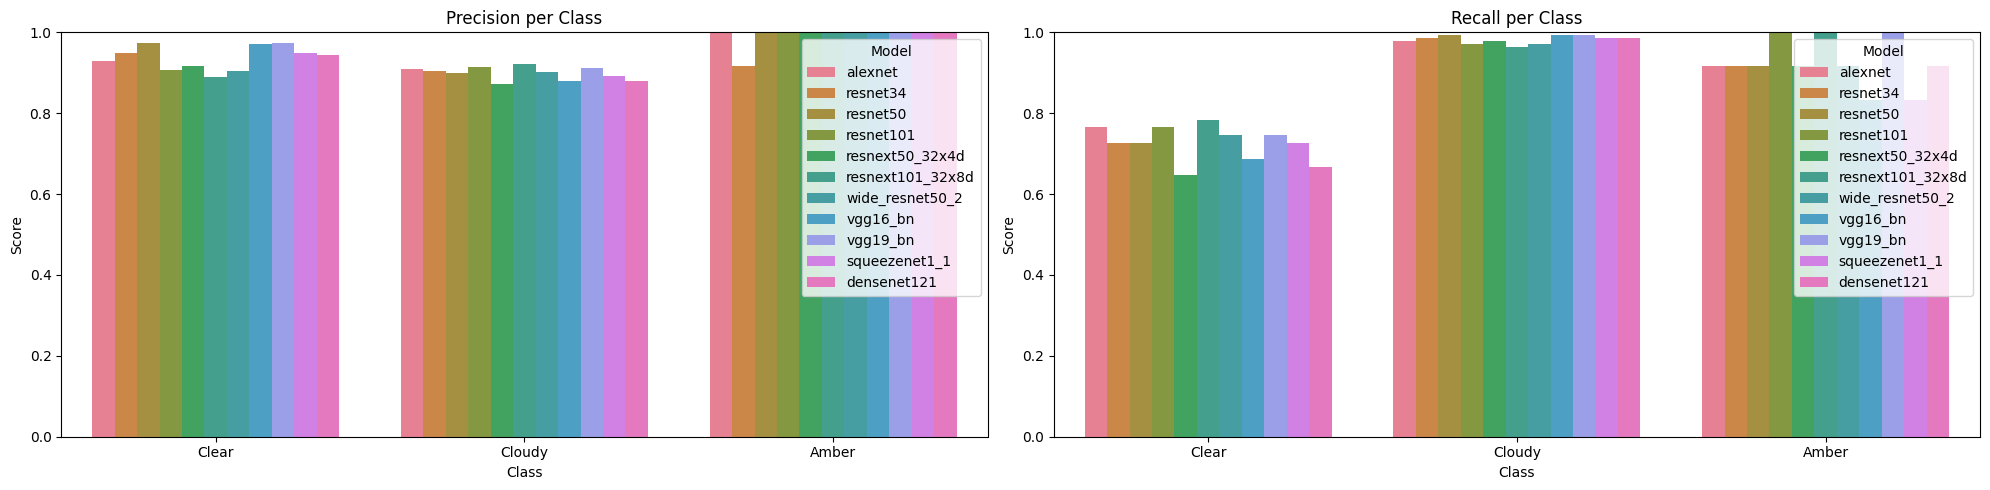

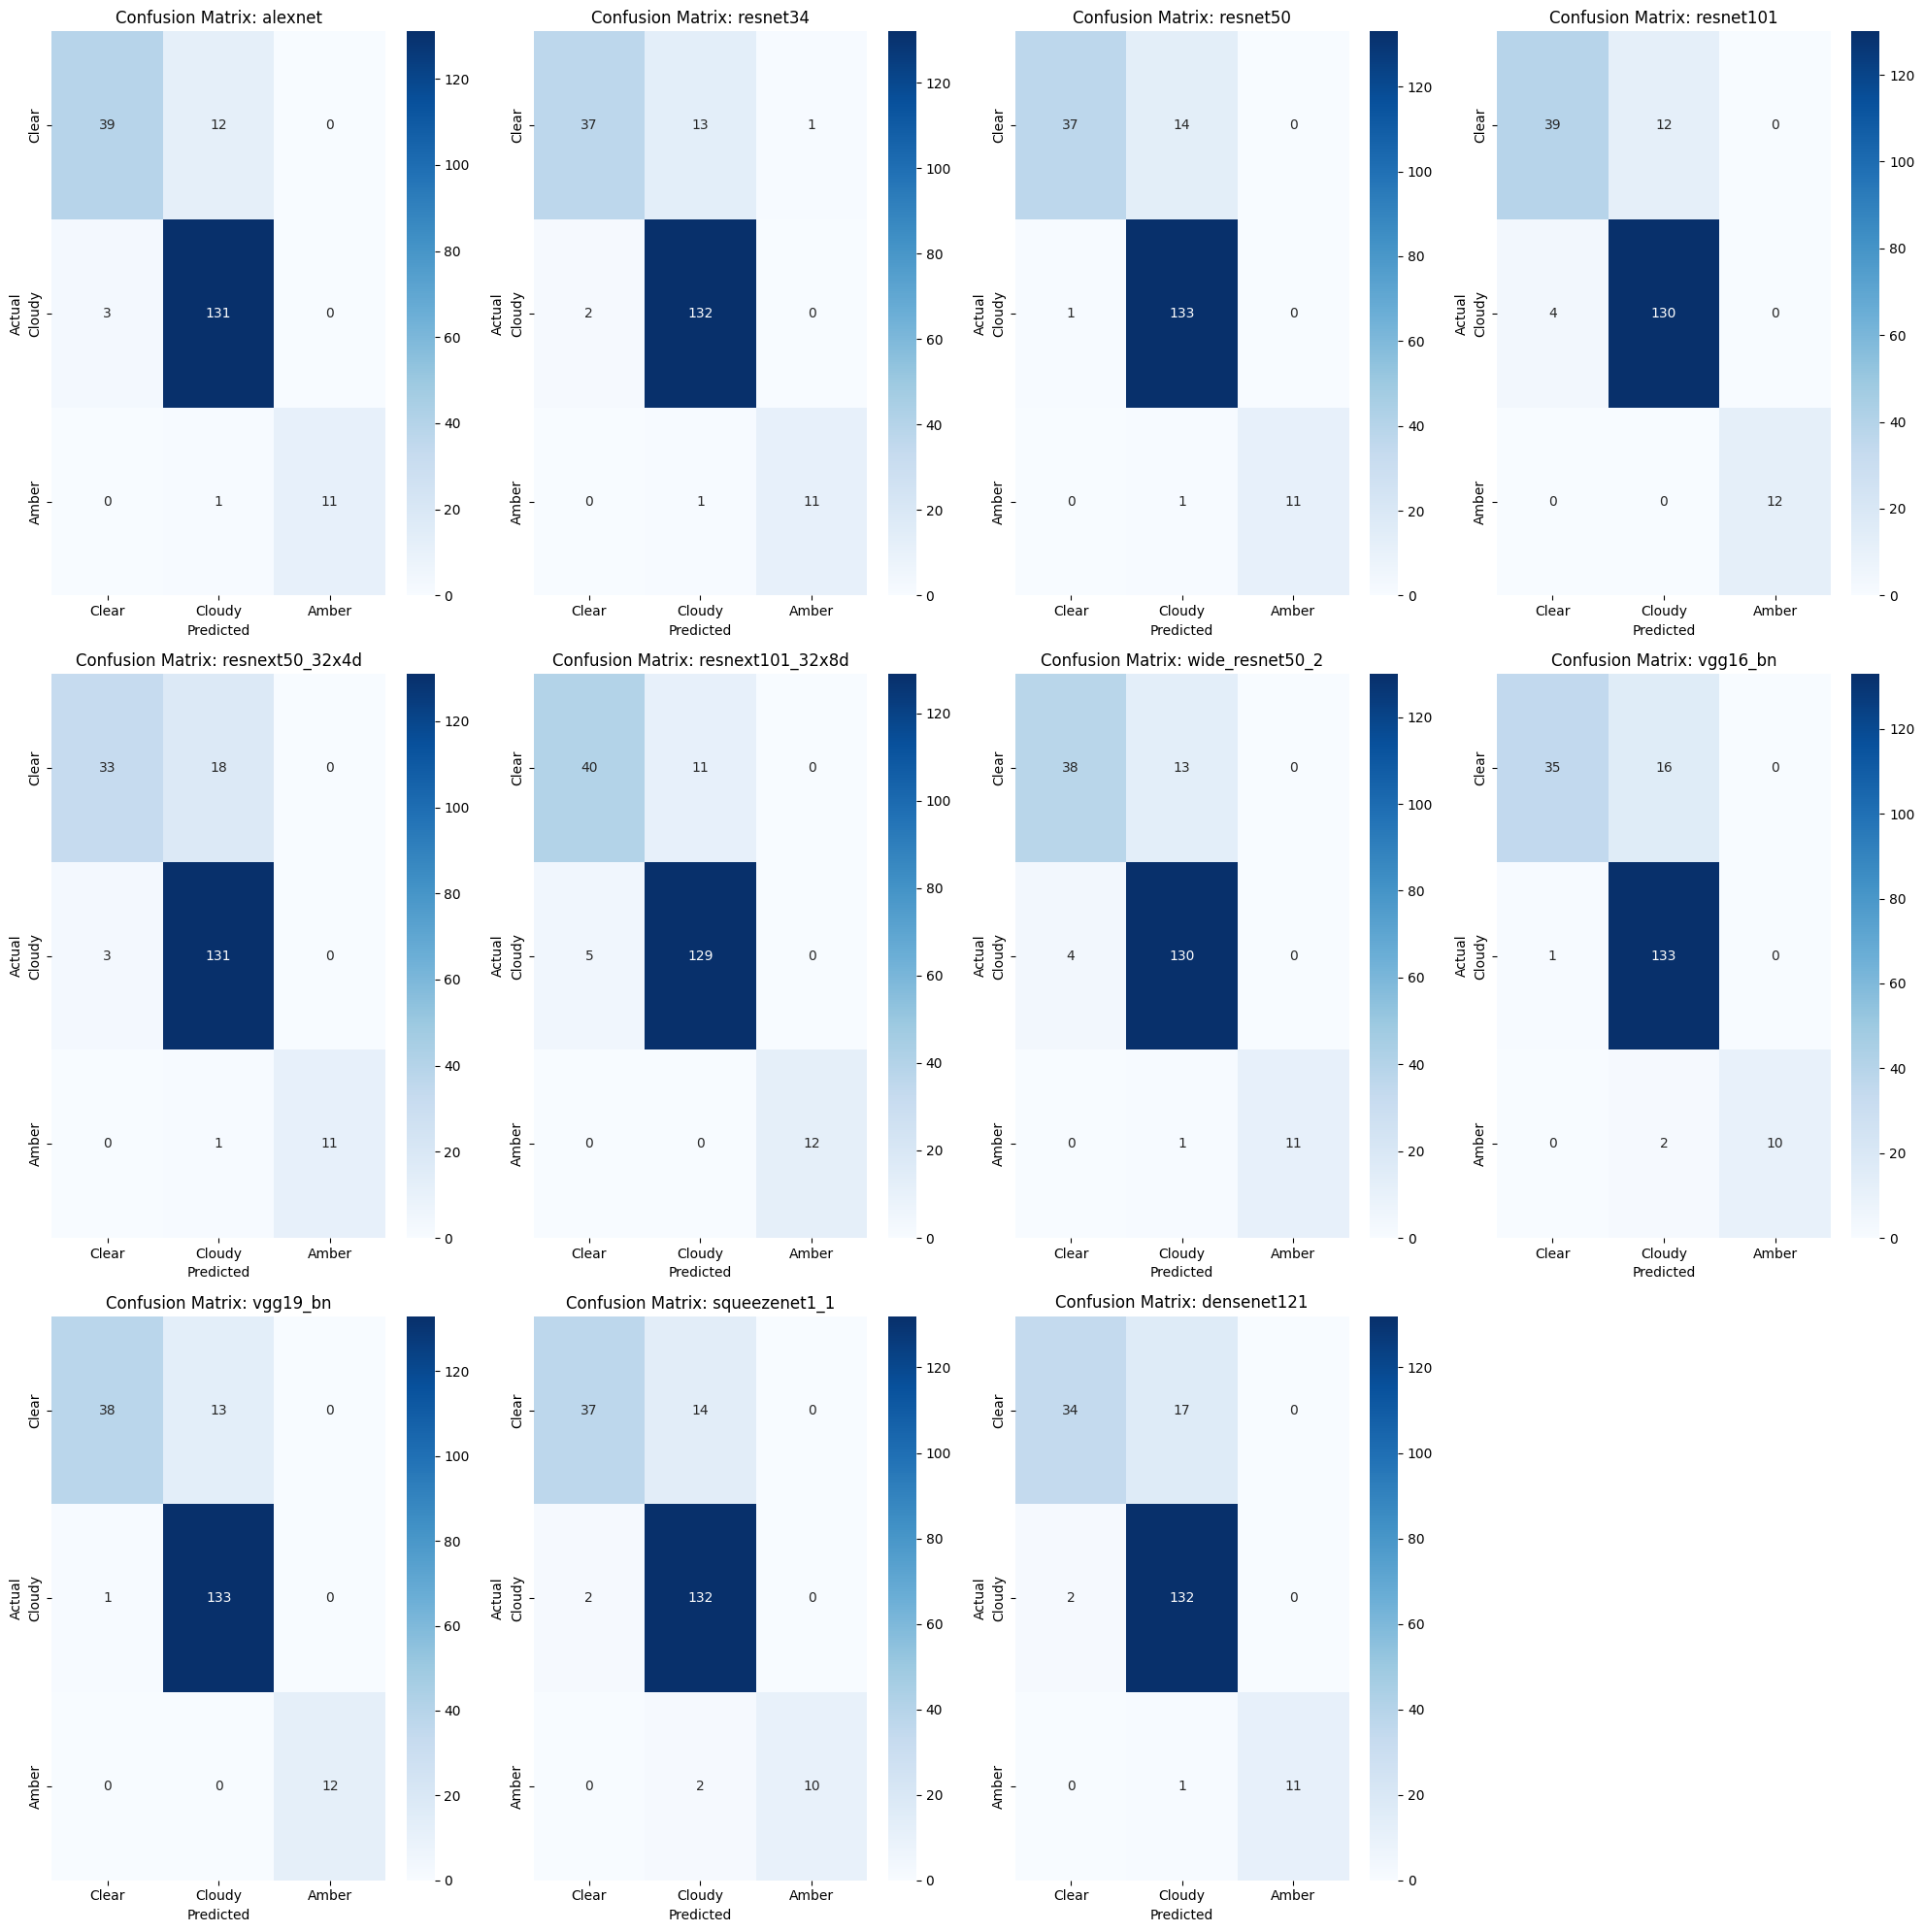

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

# Assuming results is your list of dictionaries containing model results

# Define the new order of classes
class_mapping = {0: 2, 1: 0, 2: 1}  # Mapping from old to new class indices
inverse_class_mapping = {v: k for k, v in class_mapping.items()}  # Inverse mapping

# Function to reorder classes
def reorder_classes(true_classes, pred_classes, mapping):
    true_classes_reordered = np.array([mapping[cls] for cls in true_classes])
    pred_classes_reordered = np.array([mapping[cls] for cls in pred_classes])
    return true_classes_reordered, pred_classes_reordered

# Function to reorder confusion matrix
def reorder_confusion_matrix(cm, mapping):
    cm_reordered = cm[np.ix_([mapping[i] for i in range(len(mapping))],
                             [mapping[i] for i in range(len(mapping))])]
    return cm_reordered

# Reorder classes and update results
for result in results:
    true_classes = result['true_classes']
    pred_classes = result['pred_classes']
    true_classes_reordered, pred_classes_reordered = reorder_classes(true_classes, pred_classes, class_mapping)
    result['true_classes_reordered'] = true_classes_reordered
    result['pred_classes_reordered'] = pred_classes_reordered
    result['confusion_matrix_reordered'] = reorder_confusion_matrix(result['confusion_matrix'], inverse_class_mapping)

# Function to calculate precision and recall for each class
def calculate_class_metrics(results):
    for result in results:
        true_classes = result['true_classes_reordered']
        pred_classes = result['pred_classes_reordered']

        result['precision_per_class'] = precision_score(true_classes, pred_classes, average=None)
        result['recall_per_class'] = recall_score(true_classes, pred_classes, average=None)

# Calculate class metrics
calculate_class_metrics(results)

# Extract metrics for plotting
metrics_to_plot = ["accuracy", "precision_macro", "recall_macro"]
results_dict = {result['model']: result for result in results}

# Initialize plot for metrics
num_metrics = len(metrics_to_plot)
fig, axes = plt.subplots(1, num_metrics, figsize=(20, 5), sharey=True)

for i, metric in enumerate(metrics_to_plot):
    metric_values = [results_dict[model][metric] for model in results_dict.keys()]
    models = list(results_dict.keys())
    y_pos = np.arange(len(models))

    axes[i].barh(y_pos, metric_values, align='center')
    axes[i].set_yticks(y_pos)
    axes[i].set_yticklabels(models)
    axes[i].invert_yaxis()  # Invert y-axis to have the best model on top
    axes[i].set_xlabel(metric)
    axes[i].set_title(f'Model Comparison: {metric.capitalize()}')

    # Annotate bars with values
    for j in range(len(models)):
        axes[i].text(metric_values[j] + 0.01, y_pos[j], f'{metric_values[j]:.4f}', va='center')

plt.tight_layout()
plt.show()

# Plot precision and recall for each class
def plot_class_metrics(results):
    class_labels = ['Clear', 'Cloudy', 'Amber']

    precision_data = []
    recall_data = []
    for result in results:
        model_name = result['model']
        precision_per_class = result['precision_per_class']
        recall_per_class = result['recall_per_class']
        for i, (precision, recall) in enumerate(zip(precision_per_class, recall_per_class)):
            precision_data.append({'Model': model_name, 'Class': class_labels[i], 'Score': precision})
            recall_data.append({'Model': model_name, 'Class': class_labels[i], 'Score': recall})
    
    precision_df = pd.DataFrame(precision_data)
    recall_df = pd.DataFrame(recall_data)

    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    sns.barplot(x='Class', y='Score', hue='Model', data=precision_df, ax=axes[0])
    axes[0].set_title('Precision per Class')
    axes[0].set_ylim(0, 1)

    sns.barplot(x='Class', y='Score', hue='Model', data=recall_df, ax=axes[1])
    axes[1].set_title('Recall per Class')
    axes[1].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

# Plot all confusion matrices in a grid
def plot_confusion_matrices(results_dict):
    num_models = len(results_dict)
    num_cols = 4  # Number of columns for confusion matrix grid
    num_rows = (num_models + num_cols - 1) // num_cols  # Compute required rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
    axes = axes.flatten()  # Flatten the 2D array of axes

    for i, (name, metrics) in enumerate(results_dict.items()):
        cm = metrics['confusion_matrix_reordered']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                    xticklabels=['Clear', 'Cloudy', 'Amber'],
                    yticklabels=['Clear', 'Cloudy', 'Amber'])
        axes[i].set_title(f'Confusion Matrix: {name}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Call the plotting functions
plot_class_metrics(results)
plot_confusion_matrices(results_dict)


In [ ]:
#TODO NEXT
"""
V - try to understand how can i improve the use of the dinov2 (for start it didnt recieve the best results)
V - compare more classifiers on the dinov2
- try more models that convert the images to embeddings and then with classifiers
- try to see if i can apply thresholds based on colors or other features to cluster or classify the trichomes
- try to see if i can apply some kind of clustering to the images and then classify them
- try to see if i can apply some kind of clustering to the embeddings and then classify them.
- check if i can do more transformations like i did in the time series course to the data in order to perform classification.
"""